# Setup

In [ ]:
%pip install kornia==0.4.0
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math 
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import kornia as K
import time

## Mount drive

In [ ]:
your_path = ''
from google.colab import drive
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/'+your_path
import sys
sys.path.append(path)
from utils.points import cords_to_map

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## GPU

In [ ]:
print(torch.__version__)
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  DEVICE = 'cpu'
  print('CUDA is not available.  Training on CPU ...')
else:
  DEVICE = 'cuda'
  print('CUDA is available!  Training on GPU ...')



1.6.0
CUDA is available!  Training on GPU ...


# DATA

## Define transformatiom

In [ ]:
from datasets.utils.transforms import ColorJitter, ToGray,ToTensor, get_twin, Rescale
import PIL
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample

        w, h = image.size[:2]
        new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        m = transforms.Resize((new_h, new_w), PIL.Image.BICUBIC)
        img = m(image)
        landmarks[:,:2] = landmarks[:,:2] * [new_w / w, new_h / h]
        return (img,landmarks)


## Dataset model

In [ ]:
from datasets.COCO.COCO_model import COCO_dataset



## Generate dataset and dataloader

In [ ]:
transform = transforms.Compose([Rescale((240,320)),
                                ToTensor()]) 

dataset = COCO_dataset(path+'/datasets//video_data/video3_images_labels.csv',
                                  path+'/datasets/video_data/video3_images', 
                                  transform=transform, 
                                  landmark_bool=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True)

print(len(dataset))
print(len(dataloader))
for iter, (im,label) in enumerate(dataloader):
  
  if iter>0:
    break


  

283
57


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


## Test model

### plot function

In [ ]:
from utils.plot import plot_imgs


### test

torch.Size([5, 1, 300, 3])
iteration 0/57 is running


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


torch.Size([5, 1, 300, 3])


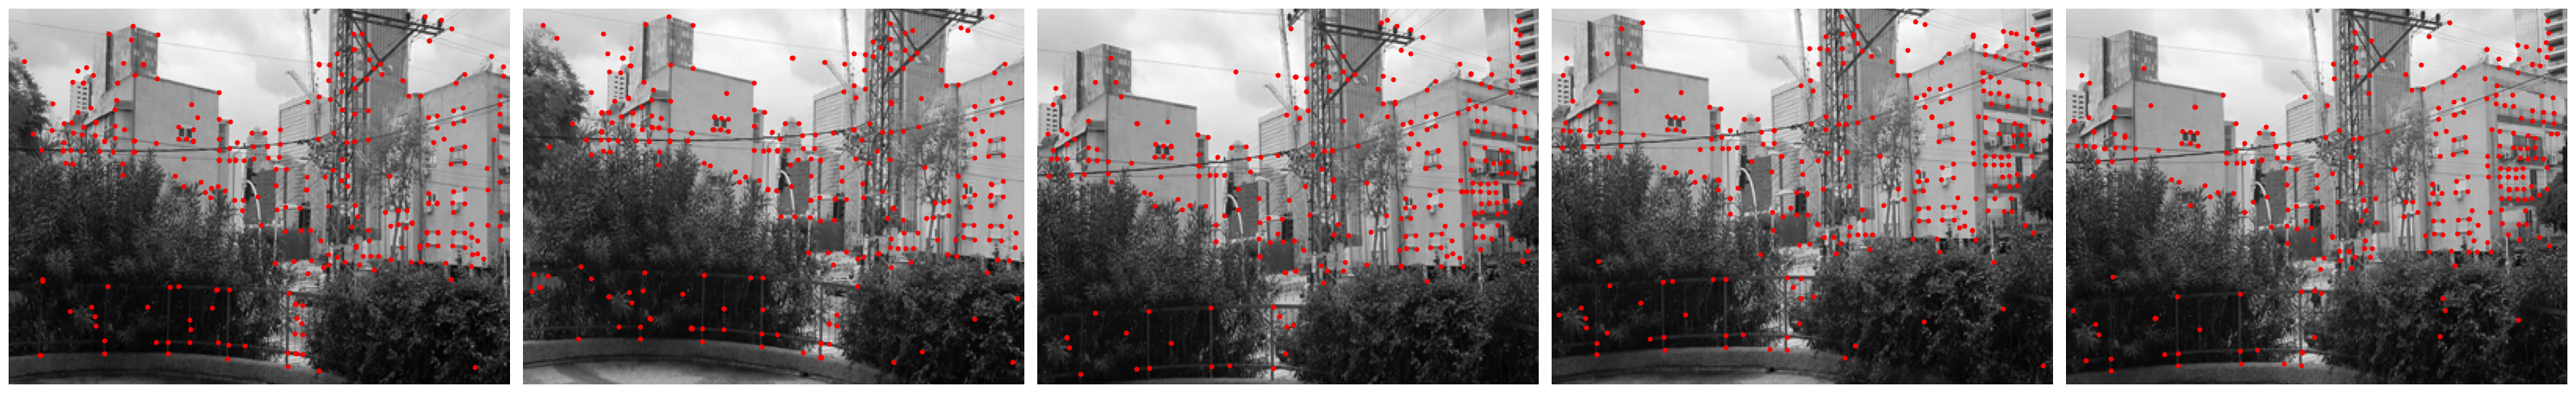

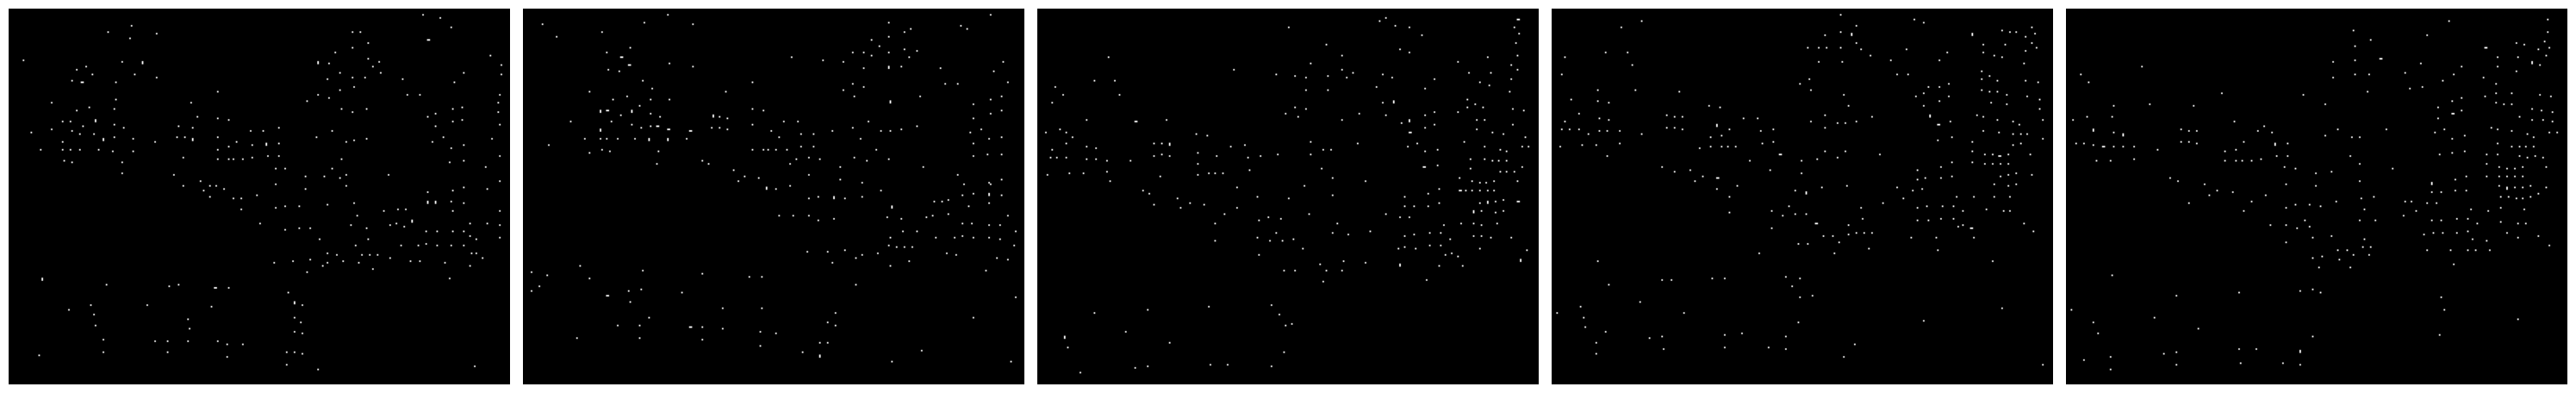

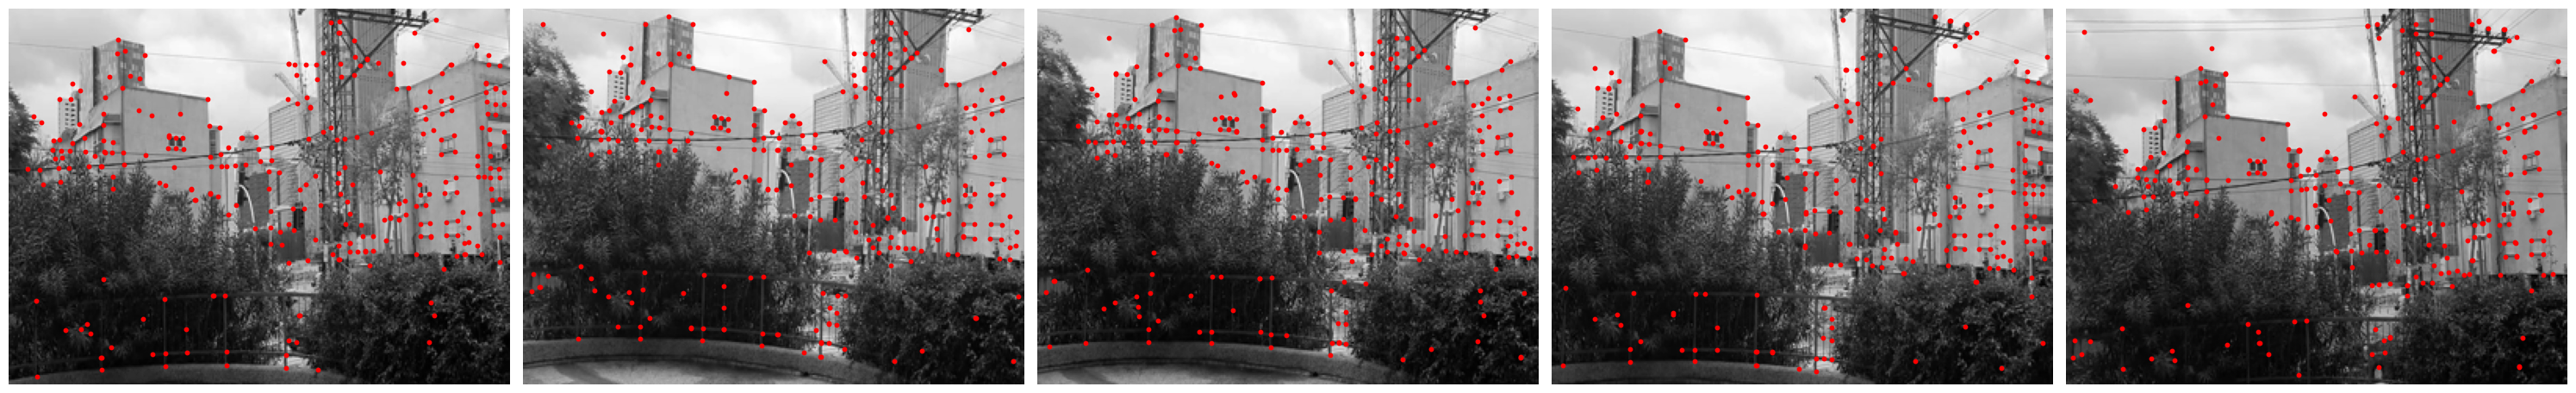

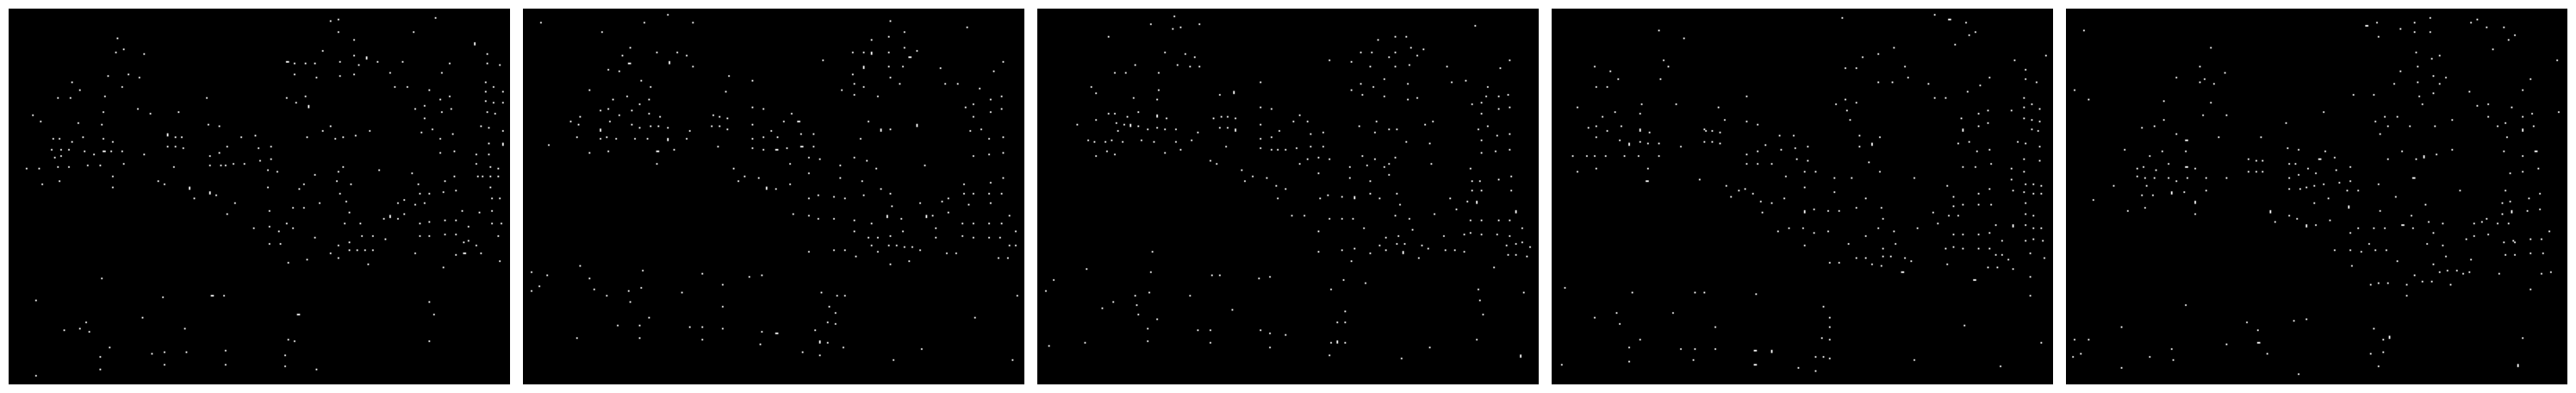

In [ ]:
for iter, (im, label) in enumerate(dataloader):
  label = label.type(torch.double)
  label = label.unsqueeze(1)
  print(label.shape)
  imgs= K.tensor_to_image(im)
  size = im.size()
  map = cords_to_map(label, size, device=False)
  im_map = K.tensor_to_image(map)
  if iter%10==0:
    print('iteration {}/{} is running'.format(iter,len(dataloader)))
  plot_imgs(imgs, label=label)
  plot_imgs(im_map)
  if iter>0:
    break

# Net architecture

## Superpoint model

In [ ]:
from models.superpoint import SuperPointNet

## functions for Loss calculations

In [ ]:
from models.utils import detector_loss, descriptor_loss


# Training Superpoint on COCO

## Train function

In [ ]:
def train_coco_magic(dataloader, net, save_path, filename, lr=0.001):
  t_0 = time.time()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
  net.to(DEVICE)
  model.train()
  N_epoch = 10
  for e in range(N_epoch):
    for iter, (im, label) in enumerate(dataloader):
      optimizer.zero_grad()
      im = im.to(DEVICE).type(torch.float)
      label = label.to(DEVICE)
    
      #get twin im and homography
      twin_im, H = get_twin(im)
      if len(H.size()) < 3:
            H = H.unsqueeze(0)
      H_invert = torch.inverse(H)
      
      #go through model
      chi_points, desc = net(im)
      twin_chi_points, twin_desc = net(twin_im)
      #get map label
      label = label.type(torch.double)
      size = im.size()
      map = cords_to_map(label, size)
      map[map<0.01] = 0
      map[:,:,0:5,0] = 0
      map[:,:,:,0:7] = 0
      map[:,:,-5:,:] = 0
      map[:,:,:,-7:] = 0      

      #get twin map and valid mask
      twin_map = map.type(torch.float)  
      twin_map = K.warp_perspective(twin_map, H, dsize=(im.size(2), im.size(3)))
      valid_mask = torch.ones_like(im, dtype=torch.float32).to(DEVICE)
      valid_mask = K.warp_perspective(valid_mask, H, dsize=(im.size(2), im.size(3)))

        
      #loss
      detector_loss_1 = detector_loss(map, chi_points)
      detector_loss_2 = detector_loss(twin_map, twin_chi_points)
      desc_loss = descriptor_loss(desc, twin_desc, H, H_invert, valid_mask)
      loss = detector_loss_1 + detector_loss_2 + 0.0001*desc_loss
      
      #optimize
      loss.backward()
      optimizer.step()
      
      
      if iter%10==0:
        print('iteration {}/{} is running'.format(e*len(dataloader)+iter,N_epoch*len(dataloader)))
        print('loss is:',loss.item())
      if iter%50==0:
        t_c = time.time()
        minute = (t_c-t_0)/60
        print('saving weights from iteration {} with loss {}, {} minutes pased'.format(e*len(dataloader)+iter,loss.item(),int(minute)))
        print('detector loss 1: {}, detector loss 2: {}, descriptor loss: {}'.format(detector_loss_1,detector_loss_2,desc_loss))
        torch.save(model.state_dict(), save_path+filename)
  # Save weights
  torch.save(model.state_dict(), save_path+filename)
  t_f = time.time()
  hours = (t_f-t_0)/3600
  print('finished in {} hours'.format(hours))

## Run

In [ ]:
#tensorflow
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os 

%load_ext tensorboard

logs_base_dir = 'logs'
os.makedirs(logs_base_dir, exist_ok=True)



dataloader = torch.utils.data.DataLoader(dataset, batch_size=3, shuffle=True)
model = SuperPointNet(superpoint_bool=True)
weights_path = path+'/pretrained_weights/superpoint_v1.pth'
model.load_state_dict(torch.load(weights_path,
                               map_location=lambda storage, loc: storage))



train_coco_magic(dataloader, model, path, '/weights/super_coco_weights_video3.pth')


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
iteration 0/950 is running


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/content/gdrive/My Drive/project_307927749_200760544/models/utils.py:48: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  cords = torch.stack(torch.meshgrid(torch.range(0,Hc-1),torch.range(0,Wc-1)), dim=-1).type(torch.int32).to(DEVICE)


loss is: 2.3589048385620117
saving weights from iteration 0 with loss 2.3589048385620117, 0 minutes pased
detector loss 1: 1.2816983461380005, detector loss 2: 1.07703697681427, descriptor loss: 1.6948449611663818
iteration 10/950 is running
loss is: 2.6835994720458984
iteration 20/950 is running
loss is: 2.501704216003418
iteration 30/950 is running
loss is: 2.165567636489868
iteration 40/950 is running
loss is: 2.254258155822754
iteration 50/950 is running
loss is: 2.0366363525390625
saving weights from iteration 50 with loss 2.0366363525390625, 0 minutes pased
detector loss 1: 1.2532342672348022, detector loss 2: 0.7832374572753906, descriptor loss: 1.6447925567626953
iteration 60/950 is running
loss is: 2.280019760131836
iteration 70/950 is running
loss is: 2.1775171756744385
iteration 80/950 is running
loss is: 2.2206342220306396
iteration 90/950 is running
loss is: 2.231564998626709
iteration 95/950 is running
loss is: 2.261855125427246
saving weights from iteration 95 with loss 

KeyboardInterrupt: ignored